<a href="https://colab.research.google.com/github/KelvinHHF/Deep-Learning/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json

In [3]:
X = np.load(r'DataSet/Assignment 2 data/X.npy')
y = np.load(r'DataSet/Assignment 2 data/y.npy')
X_test = np.load(r'DataSet/Assignment 2 data/X_test.npy')
y_test = np.load(r'DataSet/Assignment 2 data/y_test.npy')
X_test2 = np.load(r'DataSet/Assignment 2 data/X_test2.npy')

In [4]:
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
X_test2_tensor = torch.FloatTensor(X_test2)

In [5]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, hidden_size, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        out = self.fc(x[:, -1, :])  # Use the last time step's output for regression
        return out



In [6]:
# Hyperparameters
input_size = X.shape[2]
hidden_size = 64
output_size = 1
num_heads = 4  # Number of heads that divides hidden_dim
num_layers = 3  # Increase the number of transformer layers
learning_rate = 0.001
batch_size = 32  # Experiment with smaller batch size

In [7]:
# Create a dataset and a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Initialize the loss function
criterion = nn.MSELoss()


In [8]:
def train_and_evaluate(model, criterion, optimizer, dataloader, X_test_tensor, y_test_tensor, num_epochs=100):
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()  # Clear gradients

            outputs = model(batch_X)  # Forward pass

            # Squeeze the outputs to remove the extra dimension and match the target shape
            outputs = outputs.squeeze(-1)  # Shape [batch_size, 1] -> [batch_size]

            # Compute loss
            loss = criterion(outputs, batch_y)

            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

        # Print the loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    # Evaluation on the test set after training
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_pred = model(X_test_tensor)

        # Squeeze the outputs to remove the extra dimension and match the target shape
        y_pred = y_pred.squeeze()  # Shape [batch_size, 1] -> [batch_size]

        mse = criterion(y_pred, y_test_tensor).item()  # Calculate MSE

    print(f'Final Mean Squared Error on Test Set: {mse:.4f}')

    return mse

In [9]:
epoch_list = [10, 30, 50, 100]
mse_results = {}  # To store MSE results for each num_epochs configuration

for num_epochs in epoch_list:
    # Reinitialize the model for each run to ensure fresh training
    model = TransformerModel(input_size, num_heads, num_layers, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\nTraining model for {num_epochs} epochs...\n")

    # Train and evaluate the model for the current num_epochs
    final_mse = train_and_evaluate(
        model,
        criterion,
        optimizer,
        dataloader,
        X_test_tensor,
        y_test_tensor,
        num_epochs=num_epochs
    )

    # Store the final test MSE for this number of epochs
    mse_results[num_epochs] = final_mse

# Output the final MSE for each num_epochs configuration
for num_epochs, mse in mse_results.items():
    print(f"Final MSE after {num_epochs} epochs: {mse:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Training model for 10 epochs...

Epoch [10/10], Loss: 0.004653207492083311
Final Mean Squared Error on Test Set: 0.0179

Training model for 30 epochs...



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/30], Loss: 0.035059284418821335
Epoch [20/30], Loss: 0.010187242180109024
Epoch [30/30], Loss: 0.024344824254512787
Final Mean Squared Error on Test Set: 0.0300

Training model for 50 epochs...

Epoch [10/50], Loss: 0.021004702895879745
Epoch [20/50], Loss: 0.011692249216139317
Epoch [30/50], Loss: 0.01879514567553997
Epoch [40/50], Loss: 0.02347741462290287
Epoch [50/50], Loss: 0.026964908465743065
Final Mean Squared Error on Test Set: 0.0191

Training model for 100 epochs...

Epoch [10/100], Loss: 0.018817007541656494
Epoch [20/100], Loss: 0.0337018258869648
Epoch [30/100], Loss: 0.03304881229996681
Epoch [40/100], Loss: 0.03755446895956993
Epoch [50/100], Loss: 0.05074809864163399
Epoch [60/100], Loss: 0.01477537676692009
Epoch [70/100], Loss: 0.018335789442062378
Epoch [80/100], Loss: 0.0130544975399971
Epoch [90/100], Loss: 0.018955262377858162
Epoch [100/100], Loss: 0.028107548132538795
Final Mean Squared Error on Test Set: 0.0200
Final MSE after 10 epochs: 0.0179
Final

In [15]:
def plot_mse(mse_result, hyperparameter, range_list):
  log_mse = {epoch: np.log(mse) for epoch, mse in mse_results.items()}

  plt.figure(figsize=(10, 6))
  plt.plot(list(log_mse.keys()), list(log_mse.values()), marker='o', color='b', label='Log MSE')
  plt.title('Log MSE vs. Number of {}'.format(hyperparameter))
  plt.xlabel('Number of {}'.format(hyperparameter))
  plt.ylabel('Log Mean Squared Error (MSE)')
  plt.xticks(range_list)
  plt.grid(True)
  plt.legend()
  plt.show()

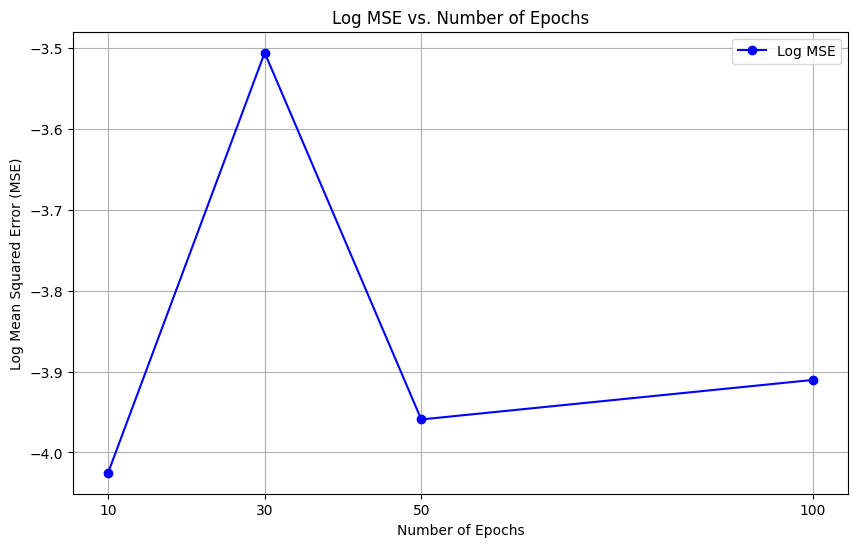

In [14]:
plot_mse(mse_results, 'Epochs',epoch_list)

Based on the result, 50 epochs got the least MSE

In [16]:
num_heads_list = [2, 4, 8]
mse_results = {}  # To store MSE results for each num_epochs configuration

for num_heads in num_heads_list:
    # Reinitialize the model for each run to ensure fresh training
    model = TransformerModel(input_size, num_heads, num_layers, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\nTraining model for {num_heads} heads...\n")

    # Train and evaluate the model for the current num_epochs
    final_mse = train_and_evaluate(
        model,
        criterion,
        optimizer,
        dataloader,
        X_test_tensor,
        y_test_tensor,
        num_epochs=50
    )

    # Store the final test MSE for this number of epochs
    mse_results[num_heads] = final_mse

# Output the final MSE for each num_epochs configuration
for num_heads, mse in mse_results.items():
    print(f"Final MSE after {num_heads} epochs: {mse:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Training model for 2 heads...

Epoch [10/50], Loss: 0.014503281563520432
Epoch [20/50], Loss: 0.017094554379582405
Epoch [30/50], Loss: 0.03283163160085678
Epoch [40/50], Loss: 0.03699197247624397
Epoch [50/50], Loss: 0.014748862013220787
Final Mean Squared Error on Test Set: 0.0197

Training model for 4 heads...

Epoch [10/50], Loss: 0.02600628137588501
Epoch [20/50], Loss: 0.014937675558030605
Epoch [30/50], Loss: 0.007270005065947771
Epoch [40/50], Loss: 0.010174858383834362
Epoch [50/50], Loss: 0.040319766849279404
Final Mean Squared Error on Test Set: 0.0190

Training model for 8 heads...

Epoch [10/50], Loss: 0.015153679996728897
Epoch [20/50], Loss: 0.012180104851722717
Epoch [30/50], Loss: 0.016940094530582428
Epoch [40/50], Loss: 0.009005197323858738
Epoch [50/50], Loss: 0.02124055288732052
Final Mean Squared Error on Test Set: 0.0192
Final MSE after 2 epochs: 0.0197
Final MSE after 4 epochs: 0.0190
Final MSE after 8 epochs: 0.0192


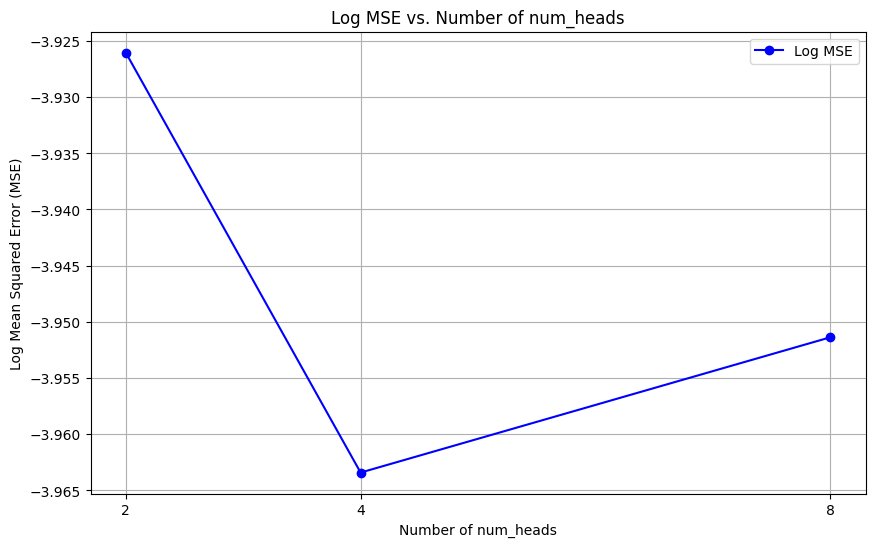

In [17]:
plot_mse(mse_results, 'num_heads',num_heads_list)

In [19]:
hidden_sizes = [16, 32, 64, 128]  # You can experiment with any values
mse_results = {}


In [21]:
for hidden_size in hidden_sizes:
    print(f"\nTraining model with hidden_size = {hidden_size}...\n")

    # Initialize the model with the current hidden size
    model = TransformerModel(input_size, num_heads, num_layers, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and evaluate the model
    final_mse = train_and_evaluate(
        model,
        criterion,
        optimizer,
        dataloader,
        X_test_tensor,
        y_test_tensor,
        num_epochs=50
    )

    # Store the final test MSE for this hidden size
    mse_results[hidden_size] = final_mse

# Output the final MSE for each hidden size
for hidden_size, mse in mse_results.items():
    print(f"Final MSE with hidden_size = {hidden_size}: {mse:.4f}")


Training model with hidden_size = 16...

Epoch [10/50], Loss: 0.00718724587932229
Epoch [20/50], Loss: 0.017682965844869614
Epoch [30/50], Loss: 0.012392621487379074
Epoch [40/50], Loss: 0.046491459012031555
Epoch [50/50], Loss: 0.045503728091716766
Final Mean Squared Error on Test Set: 0.0187

Training model with hidden_size = 32...

Epoch [10/50], Loss: 0.017077220603823662
Epoch [20/50], Loss: 0.020915286615490913
Epoch [30/50], Loss: 0.02125670574605465
Epoch [40/50], Loss: 0.007666987366974354
Epoch [50/50], Loss: 0.00843890942633152
Final Mean Squared Error on Test Set: 0.0199

Training model with hidden_size = 64...

Epoch [10/50], Loss: 0.020380936563014984
Epoch [20/50], Loss: 0.01819269359111786
Epoch [30/50], Loss: 0.015184002928435802
Epoch [40/50], Loss: 0.035453371703624725
Epoch [50/50], Loss: 0.017099598422646523
Final Mean Squared Error on Test Set: 0.0179

Training model with hidden_size = 128...

Epoch [10/50], Loss: 0.014925917610526085
Epoch [20/50], Loss: 0.00658

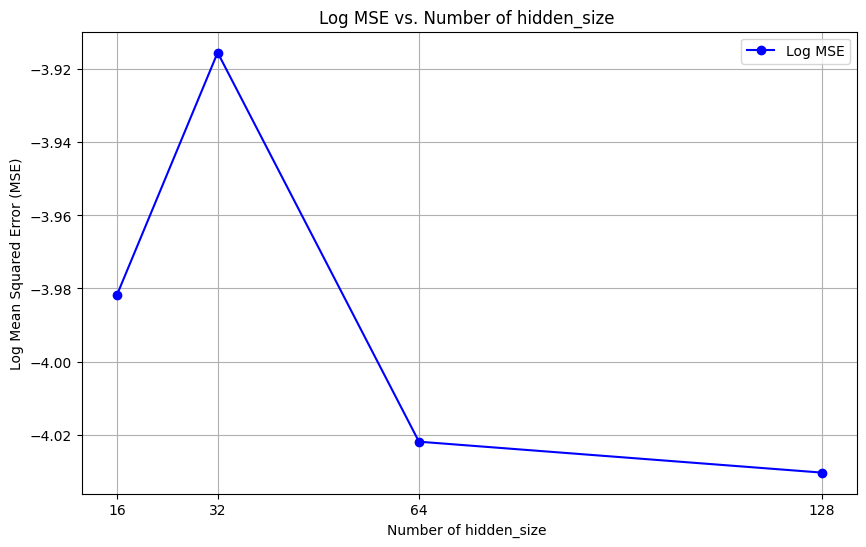

In [22]:
plot_mse(mse_results, 'hidden_size ',hidden_sizes)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!pip list

Package                          Version
-------------------------------- -------------------
absl-py                          1.4.0
accelerate                       0.34.2
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.6
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.16
albumentations                   1.4.15
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.19.0
astropy                          6.1.3
astropy-iers-data                0.2024.9.23.0.31.43
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread                        3.0.1
autograd                 